## Analysis of variant pairs

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

merged_df = pd.read_csv('merged_data.csv')

In [2]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS',
       'DAYS_BIRTH_YEAR'],
      dtype='object')

Correlation map

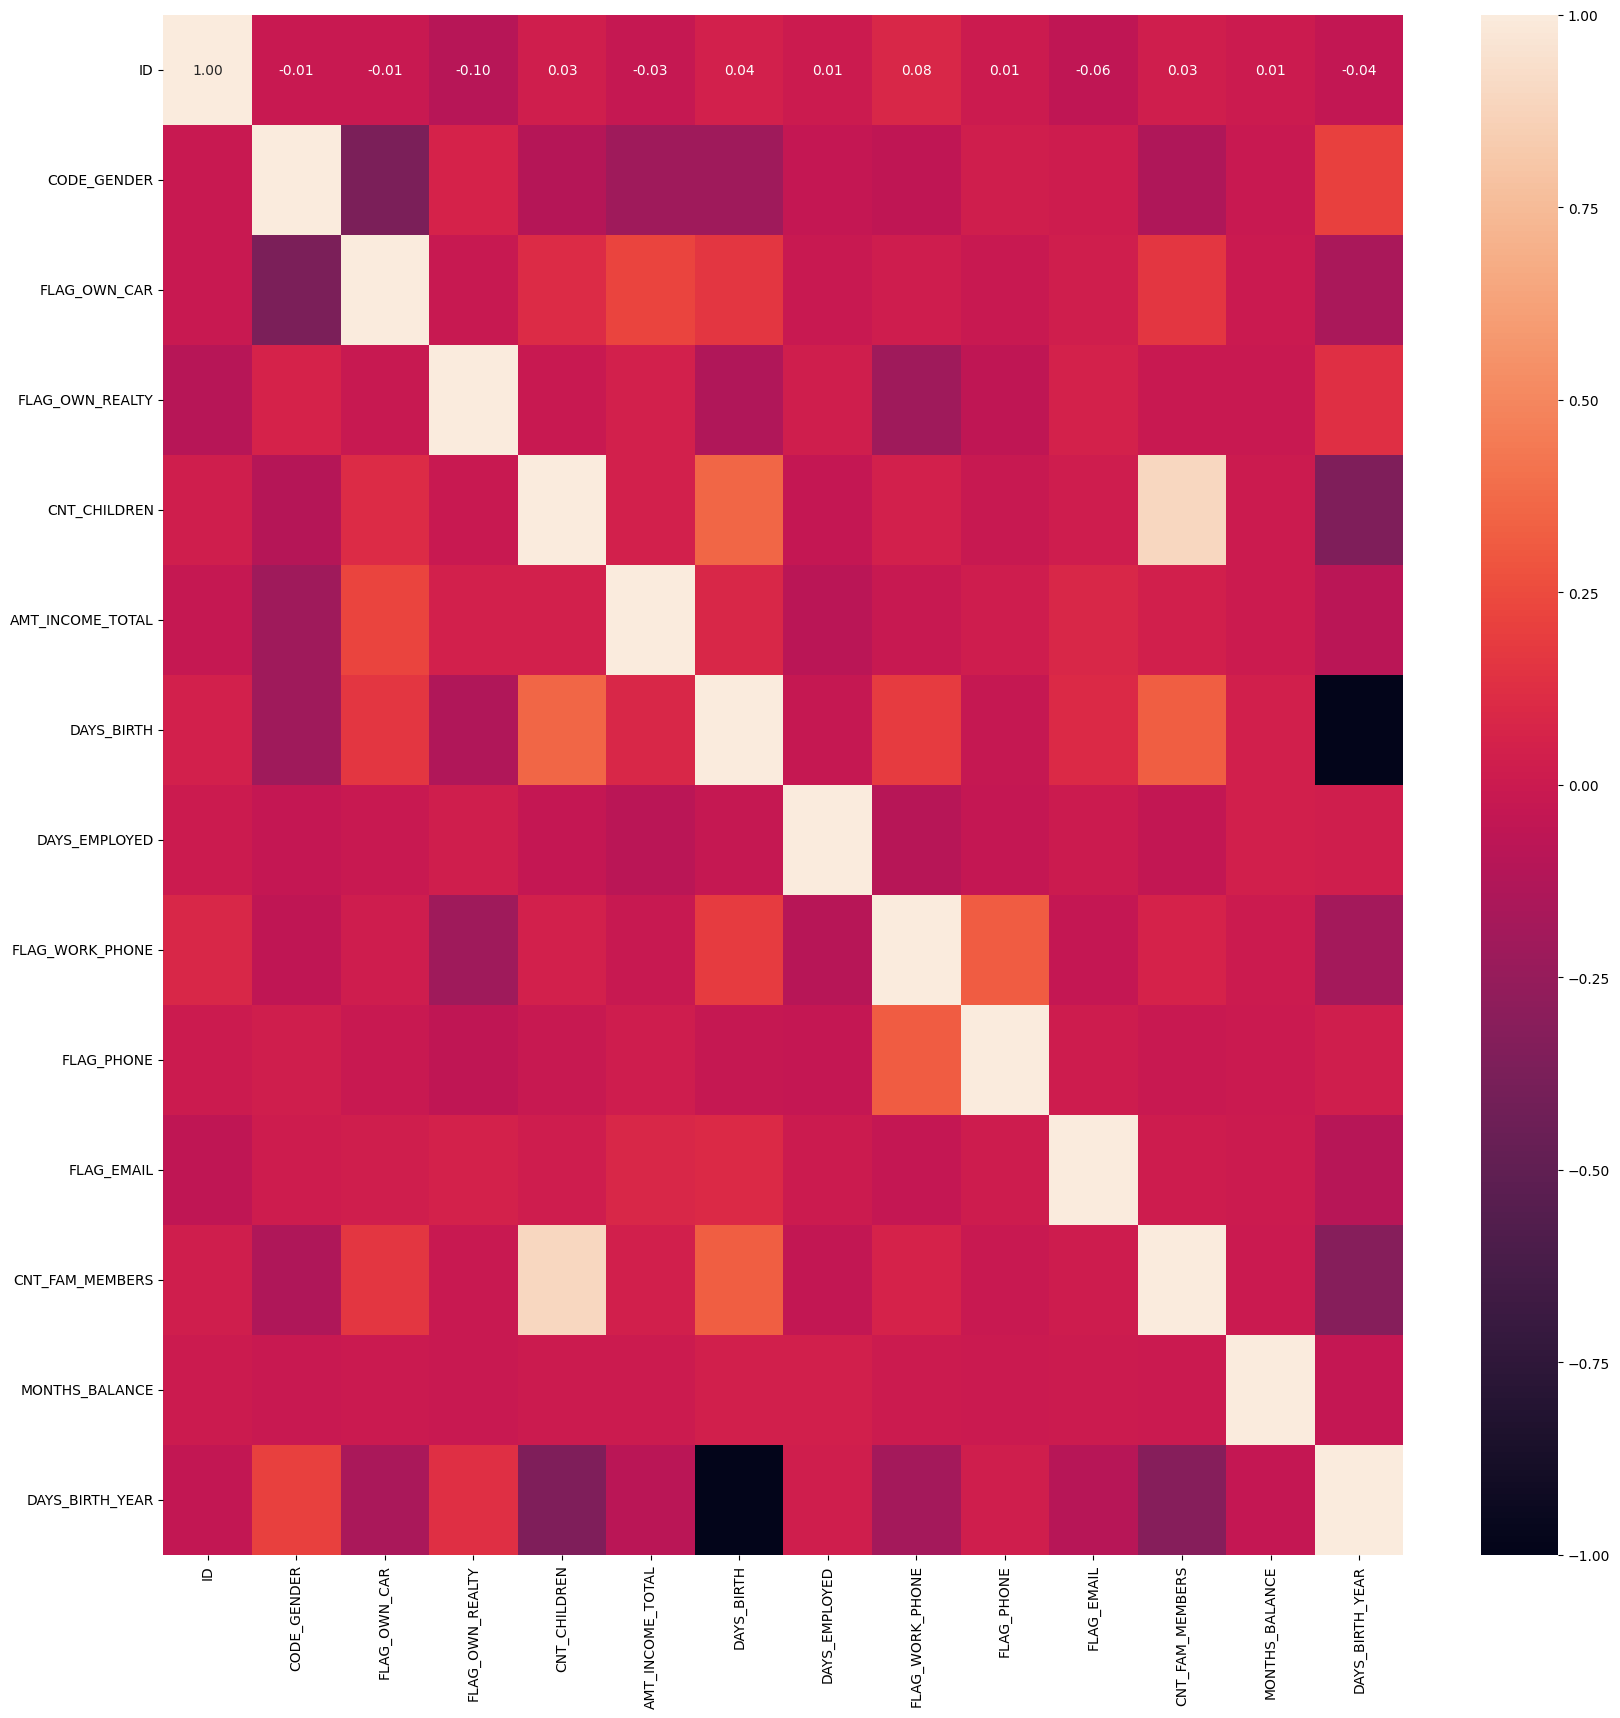

In [5]:

# select only numerical values
numerical_df = merged_df.select_dtypes(include=['int64', 'float64'])
# calculate the correlation matrix
correlation_matrix = numerical_df.corr()
# plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

The DAYS_BIRTH_YEAR column are created by me, from DAYS_BIRTH. The correlation between them is not surprising.

The number of children is closely related to the number of family members living together. This is obvious, since more children means bigger family.

Gender gap in car ownership. I had expected a bigger difference in total income.





c:\Users\User\miniconda3\envs\my-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\miniconda3\envs\my-env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


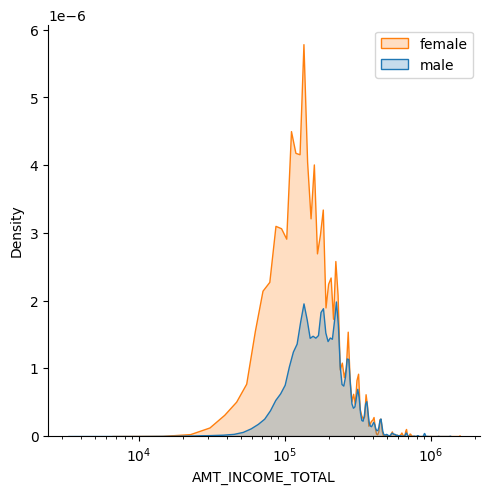

In [14]:
sns.displot(merged_df, x="AMT_INCOME_TOTAL", hue="CODE_GENDER", kind="kde", fill=True,legend=False)
plt.xscale('log')
plt.legend(['female','male'])
#legend 0 to male, 1 to femal
plt.show()



- There is more female in the dataset
- the average income is little bit higher for male

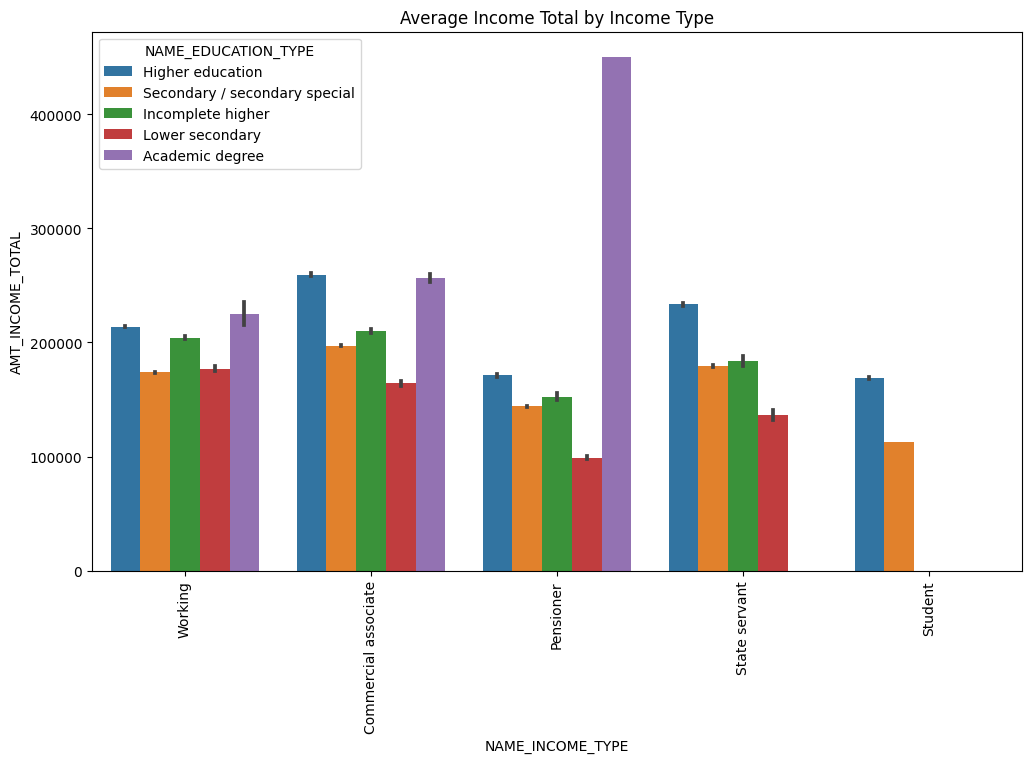

In [17]:
# visualize the average amt income total by working class
plt.figure(figsize=(12, 7))
sns.barplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL', hue="NAME_EDUCATION_TYPE", data=merged_df,estimator="mean")
plt.xticks(rotation=90)
plt.title('Average Income Total by Income Type')
plt.show()

- Individuals with incomplete higher education have moderate income levels.
- Pensioner with incomplete higher education have a lower income presence.
- State servants with higher education also have a significant income presence.

Text(0.5, 1.0, 'Income by Occupation Type')

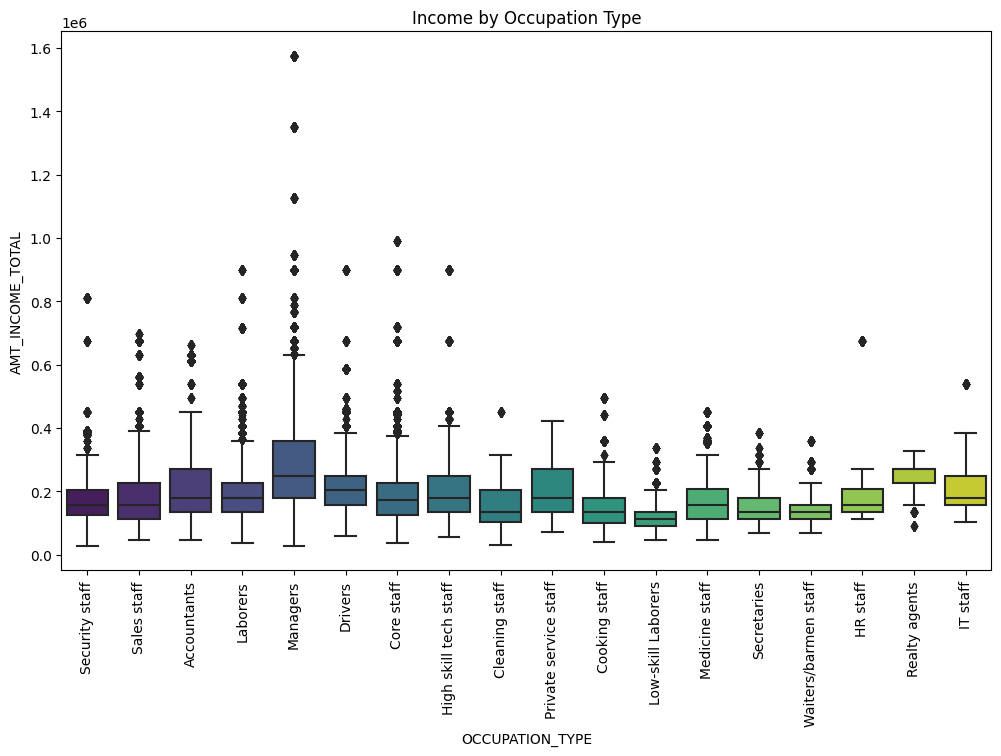

In [60]:
# boxplot of income by occupation type
plt.figure(figsize=(12, 7))


sns.boxplot(x='OCCUPATION_TYPE', y='AMT_INCOME_TOTAL', data=merged_df,palette='viridis')
plt.xticks(rotation=90)
plt.title('Income by Occupation Type')

There are outliers visible for many of the occupation types, indicating individuals who earn significantly more than their peers in the same field.

Managers have a wide range of incomes, including some high earners.

The next section inspired by: https://www.kaggle.com/code/devbilalkhan/unique-eda-with-engaging-visualizations

In [7]:
import plotly.graph_objects as go
# Group data and reset index to prepare for Sankey diagram
realty_to_housing = merged_df.groupby(['NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE'], observed=True).size().reset_index(name='count')
to_income_type = merged_df.groupby(['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS'], observed=True).size().reset_index(name='count')
to_family = merged_df.groupby(['NAME_FAMILY_STATUS', 'FLAG_OWN_REALTY'], observed=True).size().reset_index(name='count')
to_status = merged_df.groupby(['FLAG_OWN_REALTY', 'STATUS'], observed=True).size().reset_index(name='count')

# Extract unique categories for labeling
unique_house_types = realty_to_housing['NAME_HOUSING_TYPE'].unique().tolist()
unique_income_types = realty_to_housing['NAME_INCOME_TYPE'].unique().tolist()
unique_realty = to_family['FLAG_OWN_REALTY'].unique().tolist()
unique_family_status = to_income_type['NAME_FAMILY_STATUS'].unique().tolist()
unique_status = to_status['STATUS'].unique().tolist()

# Combine all labels
labels = unique_realty + unique_family_status + unique_income_types + unique_house_types + unique_status

# Map labels to indices for Sankey nodes
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Initialize lists for Sankey source, target, and value
source = []
target = []
value = []

# Populate lists with housing to income data
for _, row in realty_to_housing.iterrows():
    source.append(label_to_index[row['NAME_HOUSING_TYPE']])
    target.append(label_to_index[row['NAME_INCOME_TYPE']])
    value.append(row['count'])

# Populate lists with income to family data
for _, row in to_income_type.iterrows():
    source.append(label_to_index[row['NAME_INCOME_TYPE']])
    target.append(label_to_index[row['NAME_FAMILY_STATUS']])
    value.append(row['count'])
# Populate lists with family to realty data
for _, row in to_family.iterrows():
    source.append(label_to_index[row['NAME_FAMILY_STATUS']])
    target.append(label_to_index[row['FLAG_OWN_REALTY']])
    value.append(row['count'])

# Populate lists with realty to status data
for _, row in to_status.iterrows():
    source.append(label_to_index[row['FLAG_OWN_REALTY']])
    target.append(label_to_index[row['STATUS']])
    value.append(row['count'])

# Build and display the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="House Type / Income Type / Owns Property / Family status / Credit Status", font_size=10)
fig.show()

- The Working income type category has the highest count across all housing types. Notably, applicants living in House / apartment represent the largest subgroup, with high amount of individuals in the Working category.
- Individuals with Married Family status show a higher likelihood of owning property (1) compared to others.
- Applicants who own property (1) have a higher count of Paid off credit status, suggesting that property owners might have a better credit standing. Conversely, those without property (0) have a higher proportion in the No loan category, indicating they might be newer to credit or currently do not have loans.

In [6]:
income_bins = [27000, (27000 + 135000) / 2, 135000, (135000 + 180000) / 2, 180000, 
               (180000 + 229500) / 2, 229500, (229500 + 1575000) / 2, 1575000]

income_labels = ['Very Low income', 'Low income', 'Lower-middle income', 'Middle income', 
                 'Upper-middle income', 'Moderate-high income', 'High income', 'Very High income']

# Create 'INCOME_GROUP' feature by binning 'AMT_INCOME_TOTAL' according to defined bins and labels
merged_df['INCOME_GROUP'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=income_bins, labels=income_labels, include_lowest=True)

# Define time period bins and labels
bins = [-61, -48, -36, -24, -12, -6, 0]
labels = ['4-5 years ago', '3-4 years ago', '2-3 years ago', '1-2 years ago', '6-12 months ago', 'Within 6 months']

# Create 'TIME_PERIOD' feature by binning 'MONTHS_BALANCE' according to defined bins and labels
merged_df['TIME_PERIOD'] = pd.cut(merged_df['MONTHS_BALANCE'], bins=bins, labels=labels, right=False)


In [8]:
merged_df.dropna(inplace=True)
# Aggregating data
gender_to_edu = merged_df.groupby(['CODE_GENDER', 'INCOME_GROUP'], observed=True).size().reset_index(name='count')
to_edu = merged_df.groupby(['INCOME_GROUP', 'NAME_EDUCATION_TYPE'], observed=True).size().reset_index(name='count')
to_time_period = merged_df.groupby(['NAME_EDUCATION_TYPE', 'TIME_PERIOD'], observed=True).size().reset_index(name='count')

# Creating combined list of unique labels
unique_gender_types = gender_to_edu['CODE_GENDER'].unique().tolist()
unique_income_group = to_edu['INCOME_GROUP'].unique().tolist()
unique_edu = to_time_period['NAME_EDUCATION_TYPE'].unique().tolist()
unique_time_period = to_time_period['TIME_PERIOD'].unique().tolist()

# Combining labels
labels =  unique_gender_types + unique_income_group + unique_edu + unique_time_period

# Mapping labels to indices
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Initializing lists for Sankey diagram
source = []
target = []
value = []

# Populating source, target, and value lists
for _, row in gender_to_edu.iterrows():
    source.append(label_to_index[row['CODE_GENDER']])
    target.append(label_to_index[row['INCOME_GROUP']])
    value.append(row['count'])

for _, row in to_edu.iterrows():
    source.append(label_to_index[row['INCOME_GROUP']])
    target.append(label_to_index[row['NAME_EDUCATION_TYPE']])
    value.append(row['count'])

for _, row in to_time_period.iterrows():
    source.append(label_to_index[row['NAME_EDUCATION_TYPE']])
    target.append(label_to_index[row['TIME_PERIOD']])
    value.append(row['count'])

# Constructing the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source, target=target, value=value)
)])

# Setting title for the diagram
fig.update_layout(title_text="Gender / Income / Education Level /  Month Balance", font_size=10)

# Displaying the Sankey diagram
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


There is a notable difference in the volume of credit card applications between genders across various income levels. 

High number of applications in very low categories from females compared to males.
The trend continues in low income categories with females applying more frequently than males.
Conversely, in the high income category, the number of male applications is slightly higher than that of females.
These observations may reflect different socio-economic behaviors between genders and could indicate targeted marketing strategies by credit card companies. GENDER DISCRIMINATION may occur.

Applicants with secondary education are significantly more prevalent in the very low income group compared to those with higher education.
This trend persists into the high income group, where applicants with secondary education still constitute the majority, far outnumbering those with an academic degree.
Secondary education holders are more likely to apply for credit cards across all income groups.

In [10]:
merged_df['DAYS_EMPLOYED_YEARS'] = merged_df['DAYS_EMPLOYED'] / -365

In [21]:
import plotly.express as px
# create 4 categories for years employed
years_bins = [0, 5, 10, 20, 40]
years_labels = ['0-5 years', '5-10 years', '10-20 years', '20+ years']

# Create 'YEARS_EMPLOYED' feature by binning 'DAYS_EMPLOYED_YEARS' according to defined bins and labels
merged_df['YEARS_EMPLOYED'] = pd.cut(merged_df['DAYS_EMPLOYED_YEARS'], bins=years_bins, labels=years_labels, include_lowest=True)

# Group data and calculate aggregates
df = merged_df.groupby(["YEARS_EMPLOYED", "NAME_INCOME_TYPE"], observed=True)["AMT_INCOME_TOTAL"].agg(["count", "sum"]).reset_index()
df2 = merged_df.groupby(["YEARS_EMPLOYED", "NAME_INCOME_TYPE"], observed=True)["CNT_FAM_MEMBERS"].agg("mean").reset_index()

# Merge aggregated dataframes
df = df.merge(df2)

# Rename columns for clarity
df.columns = ["Employment Duration", "Income Type", "Income Count", "Income Amount", "Average Family Size"]

# Create scatter plot
fig = px.scatter(df, x='Income Count', y='Average Family Size', color='Employment Duration', size='Income Amount', size_max=50, hover_name='Income Type',
                 title="Avg Family Size vs. Income Count & Amount by Employment Duration & Income Type")

# Display plot
fig.show()



The data suggests a strong relationship between employment duration and financial metrics, with working individuals leading in income, and commercial associates showing higher family sizes in shorter employment terms